In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

print('Loading word vectors...')
word2vec = {}
with open(f'glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf-8') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [10]:
print('Loading in comments...')

train = pd.read_csv("Toxic_comments_data/train.csv/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


In [14]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [20]:
# because tokens are not just words, but a punctuation etc.
print(len(sequences[0]))
print(len(sentences[0].split()))

47
43


In [22]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
max word index: 19999


In [23]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [24]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [25]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [27]:
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],\
                            trainable=False, input_length=MAX_SEQUENCE_LENGTH)

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)
model = Model(input_, output)
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
r = model.fit(data, targets, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 272s 2ms/step - loss: 0.0766 - accuracy: 0.9751 - val_loss: 0.0679 - val_accuracy: 0.9769
Epoch 2/10
127656/127656 [==============================] - 271s 2ms/step - loss: 0.0649 - accuracy: 0.9778 - val_loss: 0.0652 - val_accuracy: 0.9779
Epoch 3/10
127656/127656 [==============================] - 280s 2ms/step - loss: 0.0605 - accuracy: 0.9790 - val_loss: 0.0661 - val_accuracy: 0.9775
Epoch 4/10
127656/127656 [==============================] - 278s 2ms/step - loss: 0.0568 - accuracy: 0.9799 - val_loss: 0.0670 - val_accuracy: 0.9778
Epoch 5/10
127656/127656 [==============================] - 274s 2ms/step - loss: 0.0533 - accuracy: 0.9807 - val_loss: 0.0677 - val_accuracy: 0.9774
Epoch 6/10
127656/127656 [==============================] - 275s 2ms/step

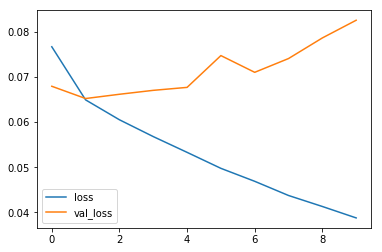

In [28]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

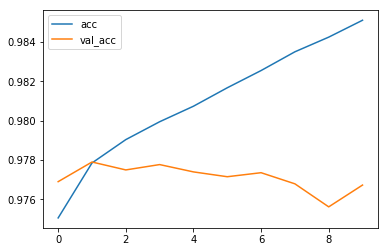

In [29]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [30]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9832214635708848
